# Download data

In [68]:
import os
import zipfile
import kaggle
# use kaggle api to download the data or manully download the data urself
## ! Kaggle competitions download -c "jane-street-real-time-market-data-forecasting" 

# make the directory to be "data/jane-street-real-time-market-data-forecasting" and extract file there u f the code dont work do it manually
## os.makedirs("data/jane-street-real-time-market-data-forecasting", exist_ok=True) # create directory for jane-street-real-time-market-data-forecasting-housing
## !unzip jane-street-real-time-market-data-forecasting.zip -d data/jane-street-real-time-market-data-forecasting/

# Kaggle Competition 

In [69]:
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [70]:
# function for import the data .parquet to pandas dataframe
def import_data(i): # the data have 10 partiton 0 to 9
    file_path = f"data/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet"
    df = pd.read_parquet(file_path)
    print(f"import train data part {i}")
    return df

In [71]:
# test/example of the import fuction
# train0 = download_data(0)
train_data = import_data(9) # there are just more data in the train.parquet partition 9

import train data part 9


In [72]:
# import test data 
file_path  = f"data/jane-street-real-time-market-data-forecasting/test.parquet/date_id=0/part-0.parquet"
test_data = pd.read_parquet(file_path)

In [73]:
# import lag data
file_path  = f"data/jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet"
lag_data = pd.read_parquet(file_path)

# Data Preprocessing

## Data cleaning

In [74]:
# feature selection ## select every feature except 0-4 
all_features_cols = [f"feature_{idx:02d}" for idx in range(79)]

lag_cols_original = ["date_id", "symbol_id"] + [f"responder_{idx}" for idx in range(9)]

#select target values
target_cols = ["responder_6"]

#select lag values
tag = ["date_id", 'symbol_id']

# select the weight values
weight_cols = ["weight"]


## drop the other responder column

## respons to nan values

In [75]:
# remove the nan values
def replace_nan_with_mean_or_zero(column):
    mean_value = column.mean()
    if pd.notnull(mean_value):
        return column.fillna(mean_value)
    else:
        return column.fillna(0)

# Create training data with lag

In [77]:
#new lag data
lags = train_data[lag_cols_original]
lags = lags.rename(columns= { f"responder_{idx}" : f"responder_{idx}_lag_1" for idx in range(9)})

lags.date_id = lags.date_id + 1
lags = lags.groupby(['date_id', 'symbol_id']).last().reset_index()  # pick up last record of previous date
train_data = train_data.merge(lags, on = ['date_id', 'symbol_id'], how = 'left')

all_features_cols= all_features_cols + [f"responder_{idx}_lag_1" for idx in range(9)]

In [20]:
# Extract features and target, and add lagged target values
# # comment out the lagged target values if you dont want to use them
# train_data['responder_6_lag_1'] = train_data.groupby(['symbol_id','time_id'])[target_cols].shift(1)
# all_features_cols= all_features_cols + ['responder_6_lag_1']

In [79]:
# Split the data into training and validation sets
train_data = train_data.apply(replace_nan_with_mean_or_zero)
max_date_id = train_data['date_id'].max()
num_val = 10
train_set = train_data[train_data['date_id'] < max_date_id - num_val]
val_set = train_data[train_data['date_id'] >= max_date_id - num_val]

In [80]:
val_set

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,responder_8,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
5860272,1688,0,0,3.917863,3.641242,2.034956,3.186726,2.876487,-2.756220,0.744516,...,0.128309,0.497190,0.203051,-1.384132,-0.251033,-0.122643,-0.076953,0.354846,0.183978,0.390437
5860273,1688,0,1,2.955504,3.096450,2.175924,2.813694,2.788037,-2.366751,0.807214,...,2.945375,-0.567836,-0.193086,-0.009620,-0.057114,-0.027312,0.522966,0.461402,0.148904,0.918688
5860274,1688,0,2,2.684425,3.691775,2.219744,2.776047,3.276349,-2.746391,1.792290,...,-0.692000,-1.075524,0.196840,-0.341488,-0.715716,-0.413005,-0.027542,0.133654,0.085567,0.291937
5860275,1688,0,3,2.493740,3.854059,1.964735,3.407585,2.990262,-2.144638,1.943719,...,0.709577,-0.009434,0.296269,0.711735,0.226703,0.113175,0.453599,0.114770,0.094785,0.217759
5860276,1688,0,4,3.570191,3.212553,2.290497,2.996184,3.239227,-2.667047,0.571937,...,-0.491592,0.298008,0.241774,2.303335,0.323491,0.147794,0.570477,0.020592,0.046038,0.012800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6274571,1698,967,34,3.242493,2.525160,-0.721981,2.544025,2.477615,0.417557,0.785812,...,-0.252461,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
6274572,1698,967,35,1.079139,1.857906,-0.790646,2.745439,2.339877,0.845065,0.651370,...,-0.460630,-1.113053,0.697190,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.324610
6274573,1698,967,36,1.033172,2.515527,-0.672298,2.289250,2.521592,0.255077,0.919892,...,-0.125170,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
6274574,1698,967,37,1.243116,2.663298,-0.889112,2.313155,3.101428,0.324454,0.618944,...,-0.256395,0.235850,0.556479,0.618944,-0.243765,-0.108361,-0.260777,-0.486923,-0.275566,-1.020708


# model

In [81]:
train_set[target_cols].min(), train_set[target_cols].max()

(responder_6   -5.0
 dtype: float32,
 responder_6    5.0
 dtype: float32)

In [82]:
from sklearn.preprocessing import MinMaxScaler

ScaleX = MinMaxScaler(feature_range=(-1,1)).fit(train_set[all_features_cols])
ScaleY = MinMaxScaler(feature_range=(-1,1)).fit(train_set[target_cols])
X_train = ScaleX.transform(train_set[all_features_cols])
y_train = ScaleY.transform(train_set[target_cols])
X_val = ScaleX.transform(val_set[all_features_cols])    
y_val = ScaleY.transform(val_set[target_cols])

In [83]:
y_train.min(), y_train.max()

(-1.0, 1.0)

In [84]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Define the parameters for the XGBRegressor
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 42,
    'device': 'cuda',          
}

# Create the XGBRegressor model with the specified parameters
model = XGBRegressor(**XGB_Params)

# Fit the model to the training data
model.fit(X_train, y_train,sample_weight=train_set[weight_cols])

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [86]:
pred = model.predict(X_val)
pred_inverse = ScaleY.inverse_transform(pred.reshape(-1, 1))
r2 = r2_score(val_set[target_cols], pred_inverse, sample_weight=val_set[weight_cols])
print(f"R2 score: {r2:.6f}")

R2 score: 0.002068


In [87]:
pred_inverse.min(), pred_inverse.max()

(-1.7510874, 1.0275995)

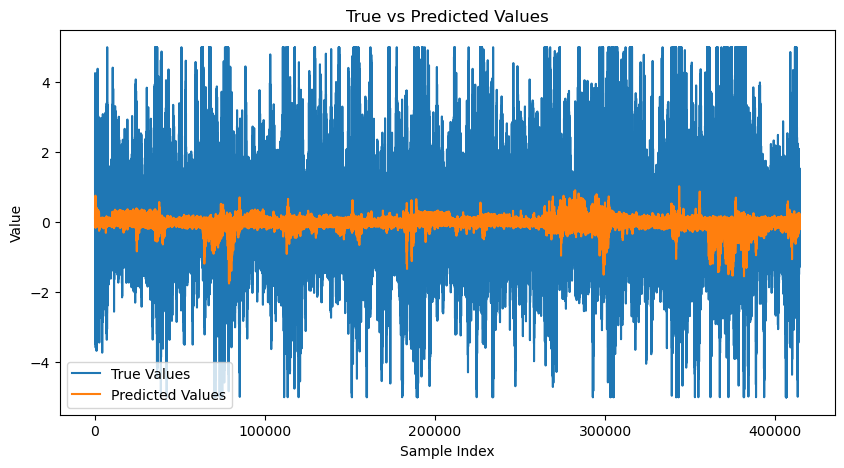

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(val_set[target_cols].reset_index(drop =True), label='True Values')
plt.plot(pred_inverse, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [125]:
def validate_n_fold(model,val_set,n_folds):
    global all_features_cols, target_cols, weight_cols, ScaleX, ScaleY
    batch_size = len(val_set)//n_folds
    X_val = ScaleX.transform(val_set[all_features_cols])    
    for i in range(0, len(val_set), batch_size):
        X_batch = X_val[i:i+batch_size]
        val_batch = val_set[i:i+batch_size]
        preds = model.predict(X_batch)
        pred_inverse = ScaleY.inverse_transform(preds.reshape(-1, 1))
        score1 = r2_score(val_batch[target_cols], pred_inverse ,sample_weight= val_batch[weight_cols])
        print(f'Batch {i//batch_size} r2_score: {score1:.6f}')

In [126]:
validate_n_fold(model, val_set, 10)

Batch 0 r2_score: 0.002455
Batch 1 r2_score: -0.012048
Batch 2 r2_score: 0.000223
Batch 3 r2_score: 0.006129
Batch 4 r2_score: 0.001274
Batch 5 r2_score: 0.007184
Batch 6 r2_score: -0.000038
Batch 7 r2_score: 0.011647
Batch 8 r2_score: 0.001997
Batch 9 r2_score: -0.002679
Batch 10 r2_score: -4.578206


# test with train data 8

In [127]:
import joblib
# save
joblib.dump(model, "XGBoost.pkl") 
joblib.dump(ScaleY, "XGBoost_scaleY.pkl")

['XGBoost_scaleY.pkl']